In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz as gr
import seaborn as sns

mpl.rcParams['figure.figsize'] = [15, 5]

# Real data (from google trends)

In [2]:
# Data taken from Google trends, which measures the popularity of search terms over time
# https://trends.google.com/trends/?geo=US
#df = pd.read_csv('https://gist.githubusercontent.com/rodonn/1f1230601238074919fbe391079f4fd0/raw/1f07a5a82cacfcbf94180e37204b461d7211082b/IceCreamDrownings.csv')
df = pd.read_csv('IceCreamDrownings.csv')

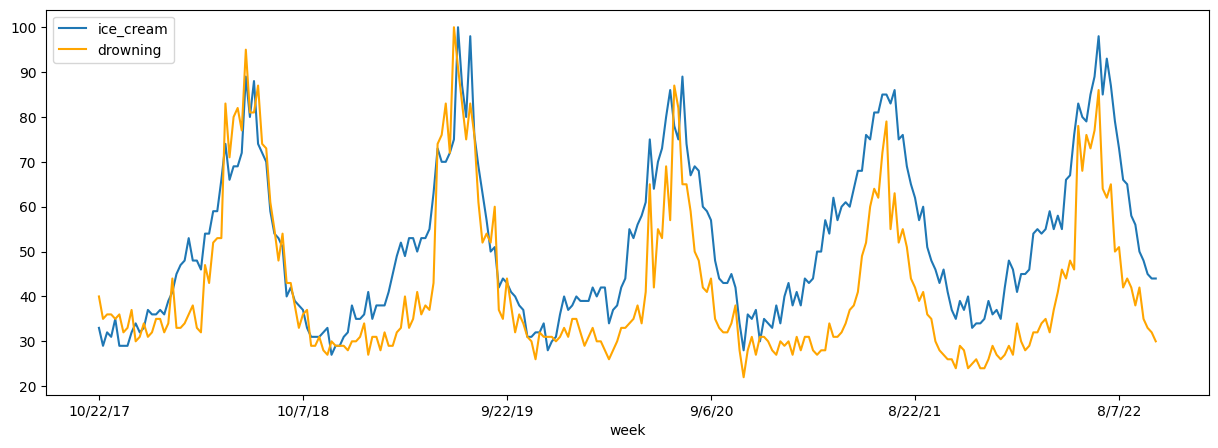

In [3]:
fig, ax = plt.subplots(figsize=(15, 5))

ax = df.plot.line('week', 'ice_cream', ax=ax)
df.plot.line('week', 'drowning', ax=ax, color="orange");

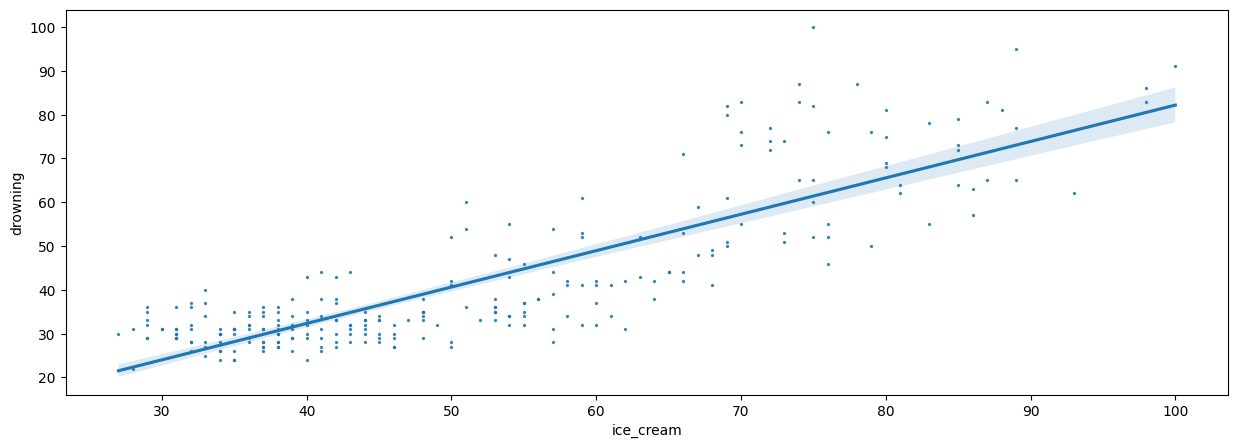

In [4]:
sns.regplot(data=df, x="ice_cream", y="drowning", scatter_kws={'s':2});

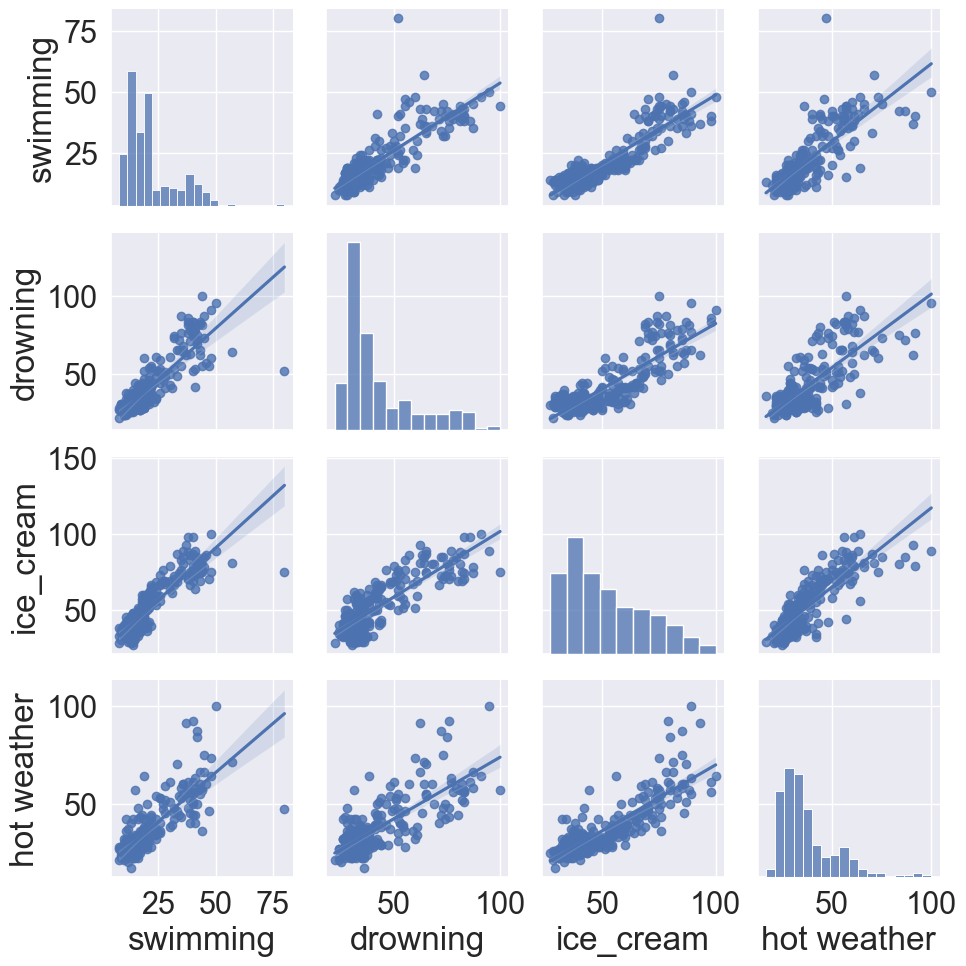

In [5]:
sns.set(font_scale=2)
sns.pairplot(df, kind="reg")
plt.savefig('Outputs/ice_cream_graph.png', transparent=True);

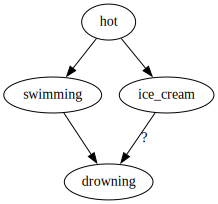

In [6]:
g = gr.Digraph()
g.edge("hot", "swimming")
g.edge("swimming", "drowning")
g.edge("hot", "ice_cream")
g.edge("ice_cream", "drowning", label="?")
g

In [7]:
g.render('Outputs/ice_cream_dag', format='png')

'Outputs/ice_cream_dag.png'

In [8]:
#!apt install libgraphviz-dev
#!pip install pygraphviz
#%pip install dowhy graphviz pygraphviz

In [9]:
from dowhy import CausalModel

In [10]:
model = CausalModel(
    data = df,
    treatment = 'ice_cream',
    outcome = 'drowning',
    graph = g.__str__()
)

In [11]:
estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                            
────────────(E[drowning|swimming])
d[ice_cream]                      
Estimand assumption 1, Unconfoundedness: If U→{ice_cream} and U→drowning then P(drowning|ice_cream,swimming,U) = P(drowning|ice_cream,swimming)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [12]:
estimate = model.estimate_effect(estimand, method_name="backdoor.linear_regression")
print(f'Causal Estimate is {estimate.value}')

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['swimming']}
Causal Estimate is 0.4732464867237507


In [13]:
import statsmodels.formula.api as smf
result = smf.ols('drowning ~ ice_cream + swimming', data=df).fit()
print(result.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2363      1.768      2.397      0.017       0.755       7.717
ice_cream      0.4354      0.062      7.020      0.000       0.313       0.557
swimming       0.7071      0.097      7.269      0.000       0.516       0.899
